In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import zipfile

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Загрузка КТ здоровых пациентов
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
filename = os.path.join(os.getcwd(), "healthy.zip")
keras.utils.get_file(filename, url)

# Загрузка КТ больных пациентов
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
filename = os.path.join(os.getcwd(), "not_healthy.zip")
keras.utils.get_file(filename, url)

# Создание директории хранения снимков
os.makedirs("Datasets")

# Распаковка архивов в созданную директорию
with zipfile.ZipFile("healthy.zip", "r") as z_fp:
    z_fp.extractall("./Datasets/")

with zipfile.ZipFile("not_healthy.zip", "r") as z_fp:
    z_fp.extractall("./Datasets/")

1045176320/1045162547 [==============================] - 155s 0us/step


In [ ]:
import nibabel as nib
from scipy import ndimage

In [ ]:
# import random

# scan = nib.load("MosMedData/CT-0/study_0001.nii.gz")
# # получает SpatialImage
# scan = scan.get_fdata()
# # scan.shape = (512, 512, 43)

# min = -1000
# max = 400
# scan[scan < min] = min
# scan[scan > max] = max
# scan = (scan - min) / (max - min)
# scan = scan.astype("float32")

# scan = ndimage.rotate(scan, 90, reshape=False)

# # Приводим к требуемому формату
# desired_depth = 64
# desired_width = 128
# desired_height = 128
# # Определение текущей глубины
# current_depth = scan.shape[-1]
# current_width = scan.shape[0]
# current_height = scan.shape[1]
# # Compute depth factor
# depth = current_depth / desired_depth
# width = current_width / desired_width
# height = current_height / desired_height
# depth_factor = 1 / depth
# width_factor = 1 / width
# height_factor = 1 / height

# scan_q = ndimage.zoom(scan, (width_factor, height_factor, 1), order=1)



# import matplotlib.pyplot as plt

# #plt.imshow(np.squeeze(scan[:, :, 33]), cmap="gray")
# #plt.imshow(np.squeeze(scan_q[:, :, 33]), cmap="gray")

# def shift_volume(scan):
    
#     shiht = [-20, -10, -5, 5, 10, 20]
#     width_shift = random.choice(shiht)
#     height_shift = random.choice(shiht)
#     scan = ndimage.shift(scan, (height_shift,width_shift,0))
#     return scan

# scan_q = shift_volume(scan_q)

# DNUM = 11

# fig_width = 12.0
# fig_height = 6.0
# heights = scan.shape[0]
# f, axarr = plt.subplots(
#         1,
#         2,
#         figsize=(fig_width, fig_height),
#         #gridspec_kw={"height_ratios": heights},
#     )
# axarr[0].imshow(scan[:, :, DNUM], cmap="gray")
# axarr[1].imshow(scan_q[:, :, DNUM], cmap="gray")
# axarr[0].axis("off")
# axarr[1].axis("off")
# #plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
# plt.show()

In [ ]:
def read_file(path):
    """Получение сырых данных"""
    scan = nib.load(path)
    # получает SpatialImage
    scan = scan.get_fdata()

    return scan


def normalize(scan):
    """Нормализация"""
    min = -1000
    max = 400
    scan[scan < min] = min
    scan[scan > max] = max
    scan = (scan - min) / (max - min)
    scan = scan.astype("float32")
    return scan


def resize_volume(scan):

    # Приводим к требуемому размеру
    required_depth = 64
    required_width = 128
    required_height = 128

    # Определение текущей глубины
    cur_depth = scan.shape[-1]
    cur_width = scan.shape[0]
    cur_height = scan.shape[1]

    # Считаем коэффициент масштабирования
    depth = cur_depth / required_depth
    width = cur_width / required_width
    height = cur_height / required_height
    depth_coef = 1 / depth
    width_coef = 1 / width
    height_coef = 1 / height

    # Поворачиваем
    scan = ndimage.rotate(scan, 90, reshape=False)

    # Изменяем размер вдоль всех осей
    scan = ndimage.zoom(scan, (width_coef, height_coef, depth_coef), order=1)
    return scan


def process_scan(path):
    
    # Прочтение скана
    scan = read_file(path)
    # Нормализация
    scan = normalize(scan)
    # Изменение ширины, высоты и глубины
    scan = resize_volume(scan)
    return scan

In [ ]:
# Папка "CT-0" содержит КТ со здоровой тканью,
# без признаков вирусной пневмонии.
healthy_scan_paths = [
    os.path.join(os.getcwd(), "Datasets/CT-0", x)
    for x in os.listdir("Datasets/CT-0")
]
# Папка "CT-23" содержит КТ, имеющие несколько помутнений вида матового стекла,
# свидетельствующие о поражении паренхимы легкого.
not_healthy_scan_paths = [
    os.path.join(os.getcwd(), "Datasets/CT-23", x)
    for x in os.listdir("Datasets/CT-23")
]

print("КТ со здоровой тканью: " + str(len(healthy_scan_paths)))
print("КТ, свидетельствующие о поражении паренхимы легкого: " + str(len(not_healthy_scan_paths)))

КТ со здоровой тканью: 100
КТ, свидетельствующие о поражении паренхимы легкого: 100


In [ ]:
# Считывает и обрабатывает сканы.
# Каждый скан масштабируется.
not_healthy_scans = np.array([process_scan(path) for path in not_healthy_scan_paths])
healthy_scans = np.array([process_scan(path) for path in healthy_scan_paths])

# Каждому КТ, свидетельствующему о поражении паренхимы легкого
# присваивается 1, нормальным КТ - 0.
not_healthy_labels = np.array([1 for _ in range(len(not_healthy_scans))])
normal_labels = np.array([0 for _ in range(len(healthy_scans))])

# Разделяет данные в соотношении 70-30 для тренировки и валидации.
x_train = np.concatenate((not_healthy_scans[:70], healthy_scans[:70]), axis=0)
y_train = np.concatenate((not_healthy_labels[:70], normal_labels[:70]), axis=0)
x_val = np.concatenate((not_healthy_scans[70:], healthy_scans[70:]), axis=0)
y_val = np.concatenate((not_healthy_labels[70:], normal_labels[70:]), axis=0)
print(
    "Количество экземпляров для тренировки и валидации - %d и %d."
    % (x_train.shape[0], x_val.shape[0])
)

Количество экземпляров для тренировки и валидации - 140 и 60.


In [ ]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):

    def scipy_rotate(volume):
        # Объявляем несколько углов поворота
        angles = [-25, -10, -5, 5, 10, 25]
        # Выбираем случайно
        angle = random.choice(angles)
        # Поворачиваем
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume

@tf.function
def shift(volume):
    
    def scipy_shift(volume):
    
        shiht = [-15, -10, -5, 5, 10, 15]
        width_shift = random.choice(shiht)
        height_shift = random.choice(shiht)
        volume = ndimage.shift(volume, (height_shift,width_shift,0))
        return volume

    augmented_volume = tf.numpy_function(scipy_shift, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Поворачиваем
    volume = rotate(volume)
    # Сдвигаем
    volume = shift(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [ ]:
# Объявляем загрузчики данных.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2 #2
# Увеличивает на лету во время тренировки.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)#2
)
# Только масштабирует.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)#2
)

Размерность КТ скана: (128, 128, 64, 1)


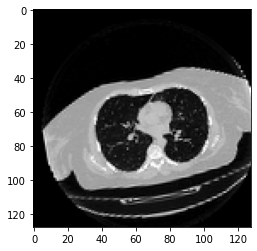

In [ ]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Размерность КТ скана:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

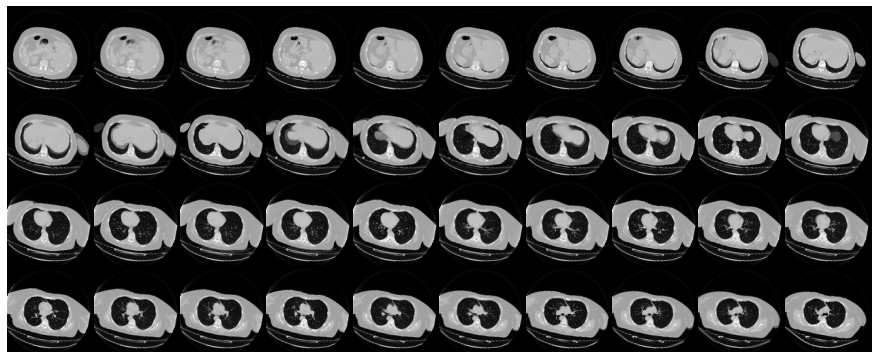

In [ ]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Визуализация серии срезов.
# 4 ряда и 10 столбцов для 40 срезов КТ.
plot_slices(4, 10, 128, 128, image[:, :, :40])

In [ ]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

#    inputs = keras.Input((width, height, depth, 1))

#     x = layers.Conv3D(filters = 64, kernel_size = 7, stride = 2, activation="relu")(inputs)      #
#     x = layers.MaxPool3D(pool_size=3, stride = 2)(x)
    
#     #starts 1st dense block
    
    
#     x = layers.Conv3D(filters=128, kernel_size=1, activation="relu", padding = "same")(inputs)
#     x = layers.BatchNormalization()(x)
#     block_1_1_out = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding = "same")(x)
#     x = layers.BatchNormalization()(x)
    
#     x = layers.Conv3D(filters=128, kernel_size=1, activation="relu", padding = "same")(block_1_1_out)
#     x = layers.BatchNormalization()(x)
#     '''block_1_2_out'''
#     x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding = "same")(x)
#     block_1_2_out = layers.BatchNormalization()(x)

#     block_1_3_in = layers.add([block_1_2_out, block_1_1_out])
    
#     x = layers.Conv3D(filters=128, kernel_size=1, activation="relu", padding = "same")(block_1_3_in)
#     x = layers.BatchNormalization()(x)
#     '''block_1_3_out'''
#     x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding = "same")(x)
#     block_1_3_out = layers.BatchNormalization()(x)
    
#     block_1_4_in = layers.add([block_1_3_out, block_1_2_out, block_1_1_out])
    
#     x = layers.Conv3D(filters=128, kernel_size=1, activation="relu", padding = "same")(block_1_4_in)
#     x = layers.BatchNormalization()(x)
#     '''block_1_4_out'''
#     x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding = "same")(x)
#     block_1_4_out = layers.BatchNormalization()(x)
    
    
#     x = layers.Conv3D(filters=128, kernel_size=1, activation="relu", padding = "same")(block_1_4_out)
#     x = layers.BatchNormalization()(x)
#     x = layers.AveragePooling3D(pool_size=2, strides = 2)(x)
#     #starts 2nd dense block
    
    
#     x = layers.Conv3D(filters=128, kernel_size=1, activation="relu", padding = "same")(x)
#     x = layers.BatchNormalization()(x)
#     #block_2_1_out
#     x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding = "same")(x)
#     block_2_1_out = layers.BatchNormalization()(x)
    
#     x = layers.Conv3D(filters=128, kernel_size=1, activation="relu", padding = "same")(block_2_1_out)
#     x = layers.BatchNormalization()(x)
#     #block_2_2_out
#     x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding = "same")(x)
#     block_2_2_out = layers.BatchNormalization()(x)

#     block_2_3_in = layers.add([block_2_2_out, block_2_1_out])
    
#     x = layers.Conv3D(filters=128, kernel_size=1, activation="relu", padding = "same")(block_2_3_in)
#     x = layers.BatchNormalization()(x)
#     #block_2_3_out
#     x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding = "same")(x)
#     block_2_3_out = layers.BatchNormalization()(x)
    
#     block_2_4_in = layers.add([block_2_3_out, block_2_2_out, block_2_1_out])
    
#     x = layers.Conv3D(filters=128, kernel_size=1, activation="relu", padding = "same")(block_2_4_in)
#     x = layers.BatchNormalization()(x)
#     #block_2_4_out
#     x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding = "same")(x)
#     block_2_4_out = layers.BatchNormalization()(x)
    
#     x = layers.GlobalAveragePooling3D()(block_2_4_out)
#     x = layers.BatchNormalization()(x)
#     x = layers.Dense(units=1000, activation="relu")(x)

#     x = layers.Dropout(0.3)(x)

# #     x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
# #     x = layers.MaxPool3D(pool_size=2)(x)
# #     x = layers.BatchNormalization()(x)

# #     x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
# #     x = layers.MaxPool3D(pool_size=2)(x)
# #     x = layers.BatchNormalization()(x)

# #     x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
# #     x = layers.MaxPool3D(pool_size=2)(x)
# #     x = layers.BatchNormalization()(x)

# #     x = layers.GlobalAveragePooling3D()(x)
# #     x = layers.Dense(units=512, activation="relu")(x)
# #     x = layers.Dropout(0.3)(x)
    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding = "same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding = "same")(x)
    x = layers.BatchNormalization()(x)
    b11_inputs = layers.MaxPool3D(pool_size=2)(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding = "same")(b11_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding = "same")(x)
    b11_outputs = layers.BatchNormalization()(x)

    b12_inputs = layers.add([b11_inputs, b11_outputs])

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding = "same")(b12_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding = "same")(x)
    b12_outputs = layers.BatchNormalization()(x)

    b13_inputs = layers.add([b12_inputs, b12_outputs])

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding = "same")(b13_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu", padding = "same")(x)
    b13_outputs = layers.BatchNormalization()(x)

    b21_inputs = layers.add([b13_inputs, b13_outputs])

    x = layers.Conv3D(filters=128, kernel_size=3, strides=2, activation="relu", padding = "same")(b21_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu", padding = "same")(x)
    b21_outputs = layers.BatchNormalization()(x)

    bm12_outputs = layers.Conv3D(filters=128, kernel_size=1, strides=2, activation="relu", padding = "same")(b21_inputs)

    b22_inputs = layers.add([bm12_outputs, b21_outputs])

    x = layers.GlobalAveragePooling3D()(b22_inputs)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Объявляем модель.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Строим модель.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 6  0           []                               
                                4, 1)]                                                            
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                , 64)                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv3d[0][0]']                 
 alization)                     , 64)                                                         

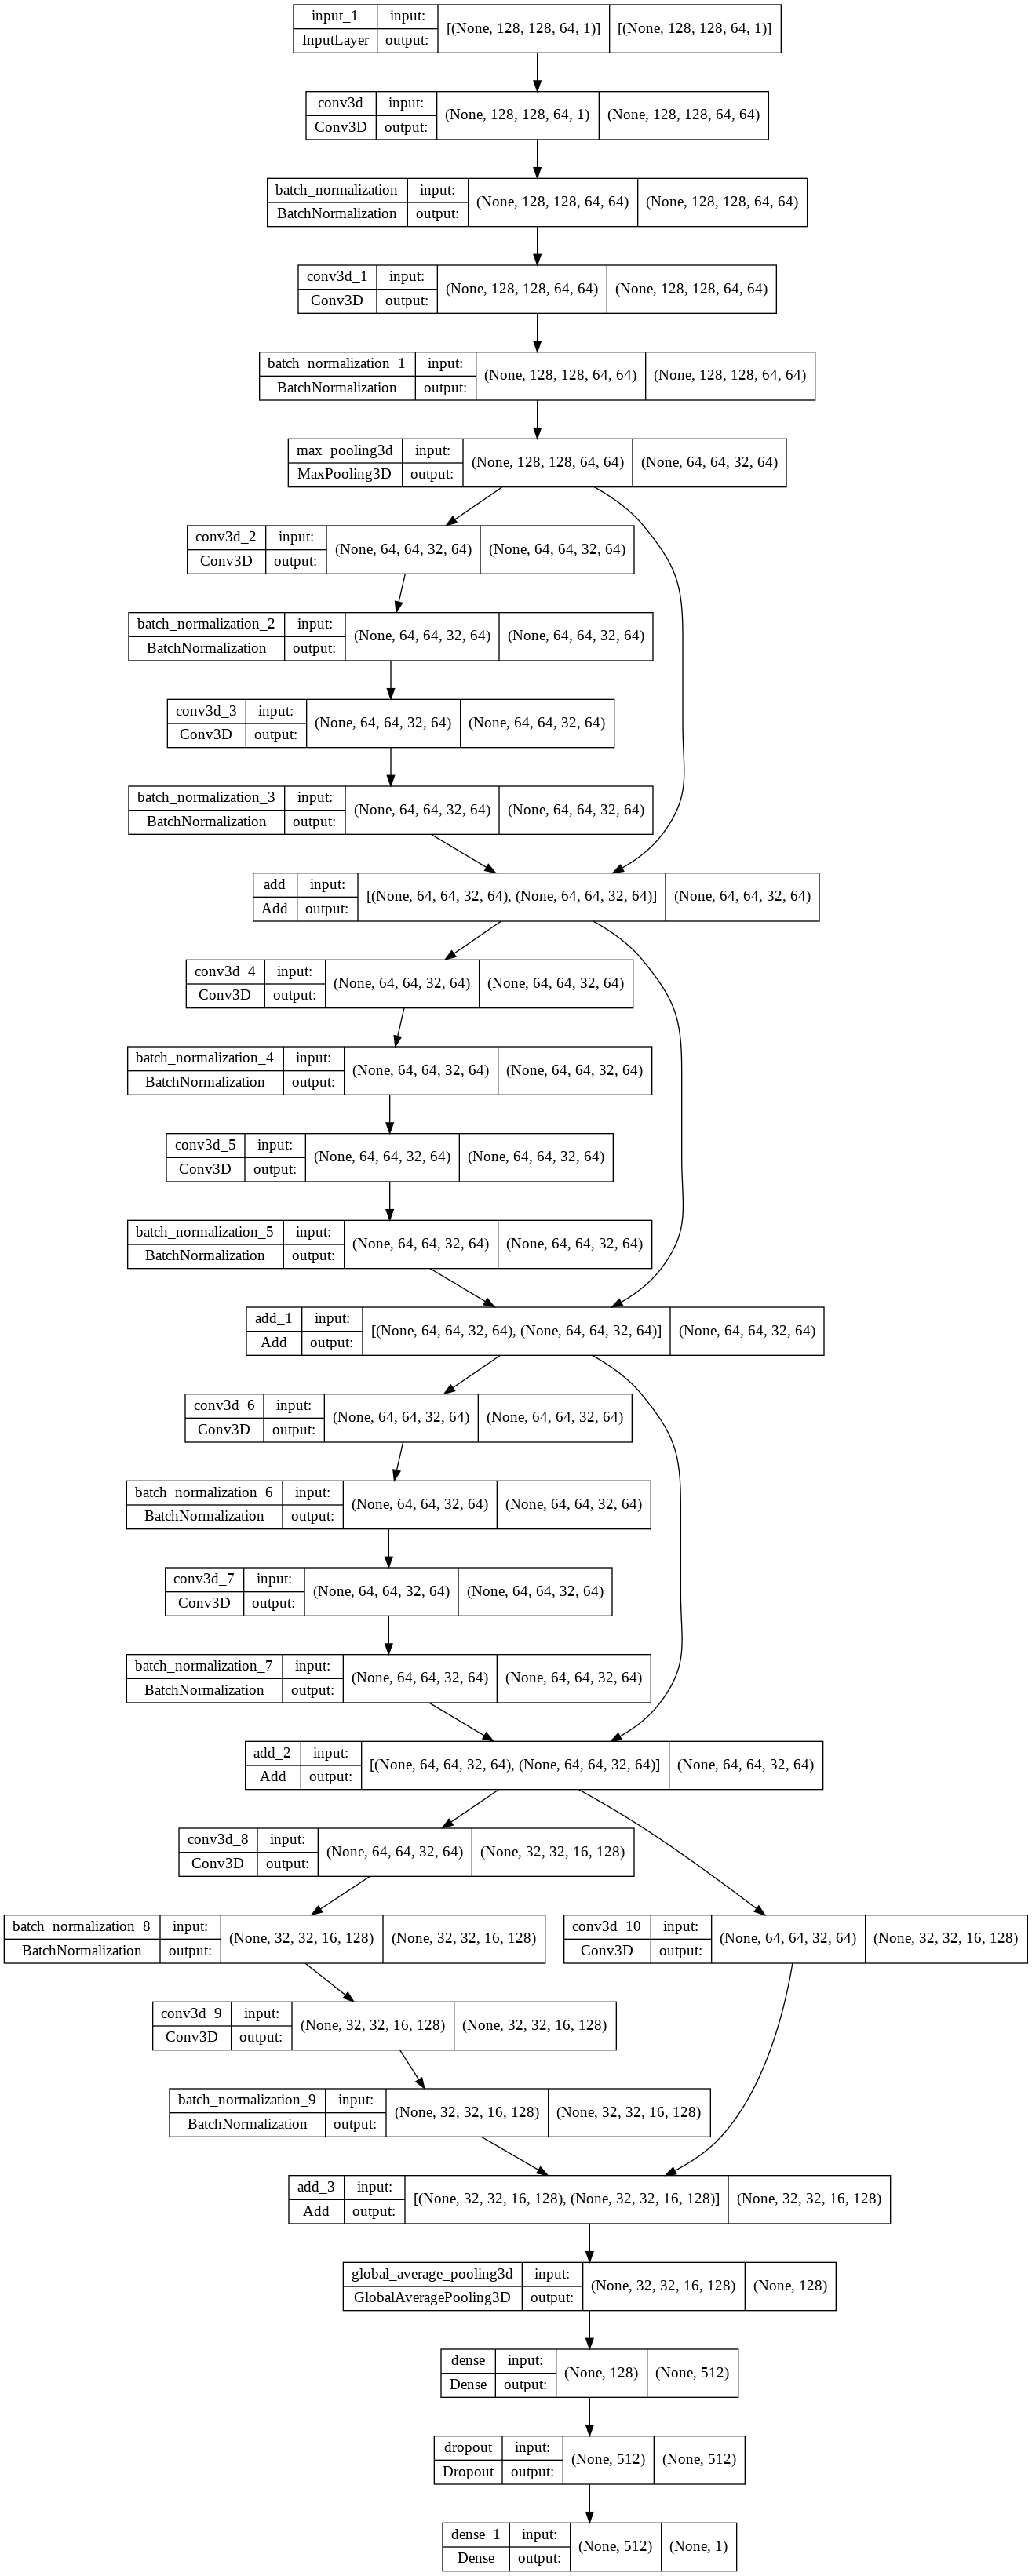

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
from keras.models import load_model

#model = load_model('3d_image_classification (1).h5')

In [ ]:
# Компиляция модели.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Определяем обратные вызовы.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=50)

# Тренируем модель, проводим валидацию в конце каждой эпохи
epochs = 150
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/150
70/70 - 132s - loss: 0.6878 - acc: 0.6071 - val_loss: 0.7512 - val_acc: 0.5000 - 132s/epoch - 2s/step
Epoch 2/150
70/70 - 116s - loss: 0.7152 - acc: 0.5571 - val_loss: 0.8910 - val_acc: 0.5000 - 116s/epoch - 2s/step
Epoch 3/150
70/70 - 116s - loss: 0.6720 - acc: 0.6214 - val_loss: 1.4664 - val_acc: 0.5000 - 116s/epoch - 2s/step
Epoch 4/150
70/70 - 116s - loss: 0.6581 - acc: 0.6357 - val_loss: 1.5029 - val_acc: 0.5000 - 116s/epoch - 2s/step
Epoch 5/150
70/70 - 116s - loss: 0.7085 - acc: 0.5000 - val_loss: 1.1023 - val_acc: 0.5000 - 116s/epoch - 2s/step
Epoch 6/150
70/70 - 115s - loss: 0.6499 - acc: 0.5929 - val_loss: 0.7559 - val_acc: 0.4500 - 115s/epoch - 2s/step
Epoch 7/150
70/70 - 115s - loss: 0.6963 - acc: 0.5786 - val_loss: 0.7889 - val_acc: 0.5500 - 115s/epoch - 2s/step
Epoch 8/150
70/70 - 115s - loss: 0.6348 - acc: 0.6214 - val_loss: 0.8650 - val_acc: 0.5000 - 115s/epoch - 2s/step
Epoch 9/150
70/70 - 115s - loss: 0.6477 - acc: 0.6143 - val_loss: 0.8587 - val_acc: 0.50

In [ ]:
# попробовать обучать с меньшей скоростью

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
# Загружаем лучшие веса сети.
model.load_weights("3d_image_classification.h5")
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["здоровых легких", "не здоровых легких"]
for score, name in zip(scores, class_names):
    print(
        "Уверенность модели - %.2f что это изображение %s"
        % ((100 * score), name)
    )

In [ ]:
predictions = model.predict(np.expand_dims(x_val[0], axis=0))
#predictions
#x_val[0]
for i in range(len(predictions)):
    if predictions[i] > 50:
      predictions[i] = 1
    else:
      predictions[i] = 0
predictions